In [ ]:
!pip uninstall keras
!pip install keras==2.2.4
!pip uninstall tensorflow
!pip install "tensorflow>=1.15,<2.0"
!pip install --upgrade tensorflow-hub
!pip install git+https://www.github.com/keras-team/keras-contrib.git

In [ ]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import spacy
warnings.simplefilter('ignore')
from pprint import pprint
nlp = spacy.load('en', disable=['parser', 'ner'])
nlp_sm = spacy.load("en_core_web_sm")

Read the file

In [ ]:
sentences_file = "/content/drive/My Drive/Bias_Lexica_Kanishka_WS1920/datasets/labeled_sentences_dataset_3.csv"
data = pd.read_csv(sentences_file, encoding='utf-8')
data = data.drop(['Unnamed: 0', 'news_link'], axis=1)
data = data.fillna(method="ffill")
data.tail(3)

,sentence,outlet,topic,type,group_id,num_sent,Label_bias,Label_opinion,biased_words,article
1697,Democrats and Republicans stood and applauded ...,usa-today,gender,center,85,1,Non-biased,Entirely factual,['saluted'],A man’s penis becomes a female penis once a ma...
1698,"As a self-described Democratic socialist, Sen....",fox-news,middle-class,right,85,1,Non-biased,Entirely factual,"['outspoken', 'self-described']","As a self-described Democratic socialist, Sen...."
1699,"During the segment, Colbert also bemoaned the ...",breitbart,white-nationalism,right,85,1,Non-biased,No agreement,['bemoaned'],CBS Late Show host Stephen Colbert claimed on ...


In [ ]:
ling_lexicon_file = "/content/drive/My Drive/Bias_Lexica_Kanishka_WS1920/datasets/linguistics/linguistic_lexicon_verb_adjective.csv"
ling_lexicon_df = pd.read_csv(ling_lexicon_file, encoding='utf-8')
ling_lexicon_df = ling_lexicon_df.fillna(method="ffill")
ling_lexicon_df = ling_lexicon_df.drop(['Unnamed: 0'], axis=1)
ling_lexicon_df.head(10)

,word,word_type,lexica_type
0,manage,verb,implicative
1,remember,verb,implicative
2,bother,verb,implicative
3,get,verb,implicative
4,dare,verb,implicative
5,care,verb,implicative
6,venture,verb,implicative
7,condescend,verb,implicative
8,happen,verb,implicative
9,see fit,verb,implicative


In [ ]:
def get_as_list(text):
  list = []
  for word in text.split():
    list.append(''.join(e.lower() for e in word if e.isalnum()))
  return list

In [ ]:
sentence_df = data.copy()
sentence_df.head(5)

,sentence,outlet,topic,type,group_id,num_sent,Label_bias,Label_opinion,biased_words,article
0,YouTube is making clear there will be no “birt...,usa-today,elections-2020,center,1,1,Biased,Somewhat factual but also opinionated,"['belated', 'birtherism']",YouTube says no ‘deepfakes’ or ‘birther’ video...
1,The increasingly bitter dispute between Americ...,msnbc,sport,left,1,1,Non-biased,Entirely factual,"['bitter', 'spilled']","FRISCO, Texas — The increasingly bitter disput..."
2,So while there may be a humanitarian crisis dr...,alternet,immigration,left,1,1,Biased,Expresses writer’s opinion,"['crisis', 'no']",Speaking to the country for the first time fro...
3,A professor who teaches climate change classes...,breitbart,environment,right,1,1,Non-biased,No agreement,['legitimate'],A professor who teaches climate change classes...
4,"Looking around the United States, there is nev...",federalist,abortion,right,1,1,Biased,Somewhat factual but also opinionated,"['killing', 'never', 'developing', 'humans', '...",The left has a thing for taking babies hostage...


In [ ]:
from spacy.tokenizer import Tokenizer
tokenizer = Tokenizer(nlp.vocab)

def tokenize_sentence(sentence):
  sequence = []
  toks = tokenizer(sentence)
  for token in toks:
    sequence.append(token.text.lower())
  return sequence

In [ ]:
sentence_df['tok_sentence'] = np.zeros(shape=(1700, 1))
for i in range(len(sentence_df)):
  sentence_df['tok_sentence'][i] = tokenize_sentence(sentence_df.sentence[i])

Read the earlier generated ELMo embeddings numpy arrays

In [ ]:
from numpy import load

embs_split_0_0to200 = load('/content/drive/My Drive/Bias_Lexica_Kanishka_WS1920/datasets/embeddings_sentences_to_elmo/X_train_embedding_matrix_split_0_until200.npy')
embs_split_0_201to425 = load('/content/drive/My Drive/Bias_Lexica_Kanishka_WS1920/datasets/embeddings_sentences_to_elmo/X_train_embedding_matrix_split_0_201to425.npy')
embs_split_1 = load('/content/drive/My Drive/Bias_Lexica_Kanishka_WS1920/datasets/embeddings_sentences_to_elmo/X_train_embedding_matrix_split_1.npy')
embs_split_2_0to298 = load('/content/drive/My Drive/Bias_Lexica_Kanishka_WS1920/datasets/embeddings_sentences_to_elmo/X_train_embedding_matrix_split_2_until298.npy')
embs_split_2_299to425 = load('/content/drive/My Drive/Bias_Lexica_Kanishka_WS1920/datasets/embeddings_sentences_to_elmo/X_train_embedding_matrix_split_2_299to425.npy')
embs_split_3 = load('/content/drive/My Drive/Bias_Lexica_Kanishka_WS1920/datasets/embeddings_sentences_to_elmo/X_train_embedding_matrix_split_3.npy')

Concatenate the embeddings

In [ ]:
embs_split_2_299to425[:127]

In [ ]:
sentence_elmo_embeddings = np.concatenate((embs_split_0_0to200[:200], embs_split_0_201to425[:225], embs_split_1, embs_split_2_0to298[:298], embs_split_2_299to425[:127], embs_split_3), axis=0)

In [ ]:
sentence_elmo_embeddings.shape

(1700, 50, 1024)

In [ ]:
xx = sentence_elmo_embeddings[0]
xx.shape

(50, 1024)

In [ ]:
print(sentence_df.tok_sentence[1699])

['during', 'the', 'segment,', 'colbert', 'also', 'bemoaned', 'the', 'fact', 'that', 'barack', 'obama', 'is', 'no', 'longer', 'president.']


In [ ]:
df_e = pd.DataFrame()
for i in range(len(sentence_elmo_embeddings)):
  emb = sentence_elmo_embeddings[i]
  emb_n = emb.reshape((emb.shape[0]*emb.shape[1]))
  df_e = df_e.append(pd.Series([emb_n]), ignore_index=True)

In [ ]:
df_e.value_counts

<bound method DataFrame.value_counts of                                                       0
0     [0.6835203170776367, 0.14839878678321838, 0.69...
1     [0.3081545829772949, 0.26630401611328125, 0.23...
2     [0.3040567636489868, 0.265319287776947, -0.180...
3     [0.3906194567680359, 0.19433127343654633, 0.36...
4     [0.10661855340003967, -0.36092594265937805, 0....
...                                                 ...
1695  [0.3535696864128113, 0.4499838650226593, 0.037...
1696  [0.277810662984848, 0.5477975606918335, 0.4144...
1697  [-0.8467962145805359, -0.19690904021263123, 0....
1698  [0.24583615362644196, -0.1305449903011322, 0.1...
1699  [0.4416966438293457, 0.5254121422767639, -0.06...

[1700 rows x 1 columns]>

In [ ]:
sentence_df['elmo_embedding'] = df_e

In [ ]:
sentence_df.head(3)

,sentence,outlet,topic,type,group_id,num_sent,Label_bias,Label_opinion,biased_words,article,tok_sentence,elmo_embedding
0,YouTube is making clear there will be no “birt...,usa-today,elections-2020,center,1,1,Biased,Somewhat factual but also opinionated,"['belated', 'birtherism']",YouTube says no ‘deepfakes’ or ‘birther’ video...,"[youtube, is, making, clear, there, will, be, ...","[0.6835203170776367, 0.14839878678321838, 0.69..."
1,The increasingly bitter dispute between Americ...,msnbc,sport,left,1,1,Non-biased,Entirely factual,"['bitter', 'spilled']","FRISCO, Texas — The increasingly bitter disput...","[the, increasingly, bitter, dispute, between, ...","[0.3081545829772949, 0.26630401611328125, 0.23..."
2,So while there may be a humanitarian crisis dr...,alternet,immigration,left,1,1,Biased,Expresses writer’s opinion,"['crisis', 'no']",Speaking to the country for the first time fro...,"[so, while, there, may, be, a, humanitarian, c...","[0.3040567636489868, 0.265319287776947, -0.180..."


In [ ]:
!pip install liwc

import liwc
parse, category_names = liwc.load_token_parser(
    '/content/drive/My Drive/Bias_Lexica_Kanishka_WS1920/datasets/linguistics/LIWC2015_English.dic'
    )

Calcuating liwc features for tokens relative to the entire sentence

In [ ]:
def get_category_counts_for_sentence(sentence):
  from collections import Counter
  liwc_cat_counts = Counter(category for token in sentence for category in parse(token))
  return liwc_cat_counts

In [ ]:
liwc_item_counts = Counter(category for token in ['stupid'] for category in parse(token))
liwc_item_counts

Counter({'adj (Adjectives)': 1,
         'affect (Affect)': 1,
         'anger (Anger)': 1,
         'negemo (Negative Emotions)': 1})

In [ ]:
liwc_item_counts['negemo (Negative Emotions)']

1

In [ ]:
def calculate_liwc_features(token, sentence):
  liwc_emb_for_token = np.zeros(shape=(5,))
  liwc_sentence_counts = get_category_counts_for_sentence(sentence)
  liwc_item_counts = Counter(category for t in [token] for category in parse(t))

  #  for token
  negemo_token_count = liwc_item_counts['negemo (Negative Emotions)']
  posemo_token_count = liwc_item_counts['posemo (Positive Emotions)']
  affective_token_count = liwc_item_counts['affect (Affect)']
  drive_token_count = liwc_item_counts['drives (Drives)']
  anger_token_count = liwc_item_counts['anger (Anger)']
  risk_token_count = liwc_item_counts['risk (Risk)']

  # For sentence
  negemo_sent_count = liwc_sentence_counts['negemo (Negative Emotions)']
  posemo_sent_count = liwc_sentence_counts['posemo (Positive Emotions)']
  affective_sent_count = liwc_sentence_counts['affect (Affect)']
  drive_sent_count = liwc_sentence_counts['drives (Drives)']
  anger_sent_count = liwc_sentence_counts['anger (Anger)']
  risk_sent_count = liwc_sentence_counts['risk (Risk)']

  # calculate relative count ratios wrt the entire sentence
  if negemo_sent_count > 0:
    negemo_rel = negemo_token_count / negemo_sent_count 
  else:
    negemo_rel = 0.0

  if posemo_sent_count > 0:
    posemo_rel = posemo_token_count / posemo_sent_count 
  else:
    posemo_rel = 0.0

  if affective_sent_count > 0:
    affective_rel = affective_token_count / affective_sent_count 
  else:
    affective_rel = 0.0
  
  if drive_sent_count > 0:
    drive_rel = drive_token_count / drive_sent_count
  else:
    drive_rel = 0.0
  
  if anger_sent_count > 0:
    anger_rel = anger_token_count / anger_sent_count
  else:
    anger_rel = 0.0

  if risk_sent_count > 0:
    risk_rel = risk_token_count / risk_sent_count
  else:
    risk_rel = 0.0

  # print(f'{negemo_rel} {posemo_rel} {affective_rel} {drive_rel} {anger_rel} {risk_rel}')

  return np.array([negemo_rel, posemo_rel, affective_rel, drive_rel, anger_rel, risk_rel])

In [ ]:
from collections import Counter
liwc_cat_counts = Counter(category for token in sentence_df.tok_sentence[0] for category in parse(token))
print(liwc_cat_counts)
print(liwc_cat_counts['function (Function Words)'])
# for i in liwc_/c_cat_counts[i]} {cat}')

Counter({'function (Function Words)': 15, 'prep (Prepositions)': 5, 'verb (Verbs)': 4, 'cogproc (Cognitive Processes)': 4, 'relativ (Relativity)': 4, 'auxverb (Auxiliary Verbs)': 3, 'space (Space)': 3, 'article (Articles)': 3, 'focuspresent (Present Focus)': 2, 'cause (Causal)': 2, 'adj (Adjectives)': 2, 'pronoun (Pronouns)': 2, 'ipron (Impersonal Pronouns)': 2, 'leisure (Leisure)': 1, 'certain (Certainty)': 1, 'percept (Perceptual Processes)': 1, 'see (See)': 1, 'adverb (Adverbs)': 1, 'focusfuture (Future Focus)': 1, 'negate (Negations)': 1, 'time (Time)': 1, 'drives (Drives)': 1, 'power (Power)': 1, 'work (Work)': 1, 'tentat (Tentative)': 1, 'compare (Comparisons)': 1, 'quant (Quantifiers)': 1})
15


In [ ]:
sentence_to_liwc(sentence_df.tok_sentence[0])

In [ ]:
def convert_to_2dnp(old, seq_length):
  return np.reshape(old, (-1, seq_length))

In [ ]:
df_elmo_liwc = pd.DataFrame()
for sentence, sentence_elmo in zip(sentence_df.tok_sentence, sentence_df.elmo_embedding):
  reshaped_elmo = convert_to_2dnp(sentence_elmo, 1024)
  new_emb = np.zeros(shape=(50, 1030))

  for i in range(len(reshaped_elmo)):
    emb = reshaped_elmo[i]
    try:
      token = sentence[i]
      liwc_feat = calculate_liwc_features(token, sentence)
      new_emb[i] = np.concatenate((emb, liwc_feat), axis=0)
    except IndexError:
      # print("index error")
      # is_all_zero = not np.any(emb)
      # print(f"embeddings all zeroes here => {is_all_zero}")
      liwc_feat = np.zeros(shape=(6,))
      new_emb[i] = np.concatenate((emb, liwc_feat), axis=0)

  new_emb = new_emb.reshape((new_emb.shape[0]*new_emb.shape[1]))
  df_elmo_liwc = df_elmo_liwc.append(pd.Series([new_emb]), ignore_index=True)

In [ ]:
df_elmo_liwc.shape

(1700, 1)

In [ ]:
sentence_df['elmo_liwc_embedding'] = df_elmo_liwc

In [ ]:
sentence_df.head(3)

,sentence,outlet,topic,type,group_id,num_sent,Label_bias,Label_opinion,biased_words,article,tok_sentence,elmo_embedding,elmo_liwc_embedding
0,YouTube is making clear there will be no “birt...,usa-today,elections-2020,center,1,1,Biased,Somewhat factual but also opinionated,"['belated', 'birtherism']",YouTube says no ‘deepfakes’ or ‘birther’ video...,"[youtube, is, making, clear, there, will, be, ...","[0.6835203170776367, 0.14839878678321838, 0.69...","[0.6835203170776367, 0.14839878678321838, 0.69..."
1,The increasingly bitter dispute between Americ...,msnbc,sport,left,1,1,Non-biased,Entirely factual,"['bitter', 'spilled']","FRISCO, Texas — The increasingly bitter disput...","[the, increasingly, bitter, dispute, between, ...","[0.3081545829772949, 0.26630401611328125, 0.23...","[0.3081545829772949, 0.26630401611328125, 0.23..."
2,So while there may be a humanitarian crisis dr...,alternet,immigration,left,1,1,Biased,Expresses writer’s opinion,"['crisis', 'no']",Speaking to the country for the first time fro...,"[so, while, there, may, be, a, humanitarian, c...","[0.3040567636489868, 0.265319287776947, -0.180...","[0.3040567636489868, 0.265319287776947, -0.180..."


In [ ]:
sentence_df.elmo_liwc_embedding[0]

array([0.68352032, 0.14839879, 0.69949836, ..., 0.        , 0.        ,
       0.        ])

In [ ]:
yy = sentence_df.elmo_liwc_embedding[0]
yy.shape

(51500,)

In [ ]:
new_yy = convert_to_2dnp(yy, 1030)
new_yy.shape

(50, 1030)

In [ ]:
# from google.colab import files
# sentence_df.to_csv(f'labeled_data_3_with_elmo.csv')

In [ ]:
# yy = sentence_df['elmo_embedding'][0]
# yy.shape

(51200,)

In [ ]:
# new_yy = convert_to_2dnp(yy, 1024)
# new_yy.shape

(50, 1024)

In [ ]:
rnn_timesteps = sentence_elmo_embeddings.shape[1]
rnn_timesteps

50

In [ ]:
# num_features = 1024 # only elmo (1024)
num_features = 1030 # elmo (1024) + liwc (6)
num_features

1030

In [ ]:
sentence_df.to_pickle('labeled_sentences_with_elmo_liwc_emb.pkl')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
!cp /content/labeled_sentences_with_elmo_liwc_emb.pkl '/content/gdrive/My Drive/Bias_Lexica_Kanishka_WS1920/datasets'

In [ ]:
df_op = pd.read_pickle('/content/gdrive/My Drive/Bias_Lexica_Kanishka_WS1920/datasets/labeled_sentences_dataset_3_with_elmo_liwc_emb.pkl')
df_op.head(3)

,sentence,outlet,topic,type,group_id,num_sent,Label_bias,Label_opinion,biased_words,article,tok_sentence,elmo_embedding,elmo_liwc_embedding
0,YouTube is making clear there will be no “birt...,usa-today,elections-2020,center,1,1,Biased,Somewhat factual but also opinionated,"['belated', 'birtherism']",YouTube says no ‘deepfakes’ or ‘birther’ video...,"[youtube, is, making, clear, there, will, be, ...","[0.6835203170776367, 0.14839878678321838, 0.69...","[0.6835203170776367, 0.14839878678321838, 0.69..."
1,The increasingly bitter dispute between Americ...,msnbc,sport,left,1,1,Non-biased,Entirely factual,"['bitter', 'spilled']","FRISCO, Texas — The increasingly bitter disput...","[the, increasingly, bitter, dispute, between, ...","[0.3081545829772949, 0.26630401611328125, 0.23...","[0.3081545829772949, 0.26630401611328125, 0.23..."
2,So while there may be a humanitarian crisis dr...,alternet,immigration,left,1,1,Biased,Expresses writer’s opinion,"['crisis', 'no']",Speaking to the country for the first time fro...,"[so, while, there, may, be, a, humanitarian, c...","[0.3040567636489868, 0.265319287776947, -0.180...","[0.3040567636489868, 0.265319287776947, -0.180..."


In [ ]:
df_op.elmo_liwc_embedding[0].shape

(51500,)

In [ ]:
cnv = convert_to_2dnp(df_op.elmo_liwc_embedding[0], num_features)
cnv.shape

(50, 1030)

In [ ]:
processable_data = sentence_df[:1696]
processable_data.tail(3)

,sentence,outlet,topic,type,group_id,num_sent,Label_bias,Label_opinion,biased_words,article,tok_sentence,elmo_embedding,elmo_liwc_embedding
1693,Issuing a defiant call to arms to grassroots R...,breitbart,trump-presidency,right,85,1,Biased,Entirely factual,"['railed', 'robbing', 'global', 'elites', 'def...",Steve Bannon cast California as a linchpin in ...,"[issuing, a, defiant, call, to, arms, to, gras...","[0.5914361476898193, 0.3794720768928528, -0.66...","[0.5914361476898193, 0.3794720768928528, -0.66..."
1694,The House Democrats’ coronavirus recovery bill...,breitbart,coronavirus,right,85,1,Biased,Expresses writer’s opinion,"['careers', 'workers', 'lose', 'foreign']",The House Democrats’ coronavirus recovery bill...,"[the, house, democrats’, coronavirus, recovery...","[0.3081545829772949, 0.26630401611328125, 0.23...","[0.3081545829772949, 0.26630401611328125, 0.23..."
1695,In every case legislators are being swarmed by...,alternet,gender,left,85,1,Biased,Expresses writer’s opinion,"['deceit', 'hysteria', 'swarmed', 'right-wing']",There are many reasons that Republicans and co...,"[in, every, case, legislators, are, being, swa...","[0.3535696864128113, 0.4499838650226593, 0.037...","[0.3535696864128113, 0.4499838650226593, 0.037..."


In [ ]:
batch_size = 32

In [ ]:
X_TRAIN = processable_data[:1440].reset_index()
X_TEST = processable_data[-256:].reset_index()

f'X_TR {len(X_TRAIN)} X_VAL {len(X_TEST)}'

'X_TR 1440 X_VAL 256'

In [ ]:
X_TRAIN.head(2)

,index,sentence,outlet,topic,type,group_id,num_sent,Label_bias,Label_opinion,biased_words,article,tok_sentence,elmo_embedding,elmo_liwc_embedding
0,0,YouTube is making clear there will be no “birt...,usa-today,elections-2020,center,1,1,Biased,Somewhat factual but also opinionated,"['belated', 'birtherism']",YouTube says no ‘deepfakes’ or ‘birther’ video...,"[youtube, is, making, clear, there, will, be, ...","[0.6835203170776367, 0.14839878678321838, 0.69...","[0.6835203170776367, 0.14839878678321838, 0.69..."
1,1,The increasingly bitter dispute between Americ...,msnbc,sport,left,1,1,Non-biased,Entirely factual,"['bitter', 'spilled']","FRISCO, Texas — The increasingly bitter disput...","[the, increasingly, bitter, dispute, between, ...","[0.3081545829772949, 0.26630401611328125, 0.23...","[0.3081545829772949, 0.26630401611328125, 0.23..."


In [ ]:
X_TEST.head(2)

,index,sentence,outlet,topic,type,group_id,num_sent,Label_bias,Label_opinion,biased_words,article,tok_sentence,elmo_embedding,elmo_liwc_embedding
0,1440,Campaigners for gender equality took to Europe...,reuters,gender,center,73,1,Non-biased,Entirely factual,['fired'],LONDON (Reuters) - Campaigners for gender equa...,"[campaigners, for, gender, equality, took, to,...","[-0.9408144950866699, -0.6641639471054077, 0.3...","[-0.9408144950866699, -0.6641639471054077, 0.3..."
1,1441,"For the latest grisly example of hypocrisy, “p...",breitbart,gender,right,73,1,Biased,Expresses writer’s opinion,"['Deep', 'State', 'entrenchment', 'progressive...","For the latest grisly example of hypocrisy, “p...","[for, the, latest, grisly, example, of, hypocr...","[0.16006621718406677, 0.3410923182964325, 0.09...","[0.16006621718406677, 0.3410923182964325, 0.09..."


In [ ]:
X_TRAIN_EMB = np.zeros(shape=(len(X_TRAIN), rnn_timesteps, num_features))
X_TEST_EMB = np.zeros(shape=(len(X_TEST), rnn_timesteps, num_features))

In [ ]:
c = 0
for emb in X_TRAIN['elmo_liwc_embedding']:
  emb_rs = convert_to_2dnp(emb, num_features)
  X_TRAIN_EMB[c] = emb_rs
  c += 1

In [ ]:
X_TRAIN_EMB.shape

(1440, 50, 1030)

In [ ]:
X_TRAIN_EMB[0][1].shape

(1030,)

In [ ]:
c = 0
for emb in X_TEST['elmo_liwc_embedding']:
  emb_rs = convert_to_2dnp(emb, num_features)
  X_TEST_EMB[c] = emb_rs
  c += 1

In [ ]:
X_TEST_EMB.shape

(256, 50, 1030)

In [ ]:
X_TEST_EMB[1][49].shape

(1030,)

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import keras
from keras import backend as K
sess = tf.Session()
K.set_session(sess)

Using TensorFlow backend.


In [ ]:
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [ ]:
from keras_contrib.layers import CRF
from keras.models import Sequential, Model, Input
from keras.layers import Embedding, Bidirectional, LSTM, Lambda, TimeDistributed, Dense, Dropout, Masking, RepeatVector
from keras.layers.merge import add
from keras.layers.advanced_activations import LeakyReLU

In [ ]:
import logging
tf.get_logger().setLevel(logging.ERROR)

Create a masking value so that the 0 vectors (PADDING) of length 1024 are masked by the network

In [ ]:
mask_value = np.zeros(shape=(num_features, ))

In [ ]:
input_text = Input(shape=(rnn_timesteps, num_features), dtype=tf.float32)

masking = Masking(mask_value=mask_value)(input_text)

# Encoding layers
lstm_1 = LSTM(units=512,
              return_sequences=True, recurrent_dropout=0.2, dropout=0.2)(masking)

bilstm_2 = Bidirectional(LSTM(units=256,
                              return_sequences=False, recurrent_dropout=0.2, dropout=0.2))(lstm_1)

rv = RepeatVector(n=rnn_timesteps)(bilstm_2)

# Decoding layers
bilstm_3 = Bidirectional(LSTM(units=256, return_sequences=True, 
                             recurrent_dropout=0.2, dropout=0.2))(rv)

lstm_4 = LSTM(units=512,
               return_sequences=True, recurrent_dropout=0.2, dropout=0.2)(bilstm_3)   

out = TimeDistributed(Dense(units=num_features))(lstm_4)   

model = Model(input_text, out)
model.compile(optimizer="adam", loss='mae')                                  

In [ ]:
# model = keras.Sequential()
# model.add(LSTM(units=128, input_shape=(50, 1024)))
# model.add(Dropout(rate=0.2))
# model.add(RepeatVector(n=50))
# model.add(LSTM(units=128, return_sequences=True))
# model.add(Dropout(rate=0.2))
# model.add(TimeDistributed(Dense(units=1024)))
# model.compile(loss='mae', optimizer='adam')

In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 1030)          0         
_________________________________________________________________
masking_1 (Masking)          (None, 50, 1030)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 128)           593408    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 50, 128)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 128)           98816     
_________________________________________________________________
lstm_4 (LSTM)                (None, 50, 128)           131584    
__________

In [ ]:
batch_size = 32
history = model.fit(
    X_TRAIN_EMB, X_TRAIN_EMB, 
    epochs=100, 
    batch_size=batch_size, 
    validation_split=0.1, 
    verbose=1,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], 
    shuffle=False)

Train on 1296 samples, validate on 144 samples
Epoch 1/100
1296/1296 [==============================] - 30s 23ms/step - loss: 0.1861 - val_loss: 0.1732
Epoch 2/100
1296/1296 [==============================] - 24s 19ms/step - loss: 0.1779 - val_loss: 0.1610
Epoch 3/100
1296/1296 [==============================] - 25s 19ms/step - loss: 0.1692 - val_loss: 0.1590
Epoch 4/100
1296/1296 [==============================] - 24s 19ms/step - loss: 0.1683 - val_loss: 0.1590
Epoch 5/100
1296/1296 [==============================] - 24s 19ms/step - loss: 0.1658 - val_loss: 0.1522
Epoch 6/100
1296/1296 [==============================] - 24s 19ms/step - loss: 0.1640 - val_loss: 0.1521
Epoch 7/100
1296/1296 [==============================] - 24s 19ms/step - loss: 0.1639 - val_loss: 0.1501
Epoch 8/100
1296/1296 [==============================] - 24s 19ms/step - loss: 0.1627 - val_loss: 0.1504
Epoch 9/100
1296/1296 [==============================] - 24s 19ms/step - loss: 0.1626 - val_loss: 0.1497
Epoch 10

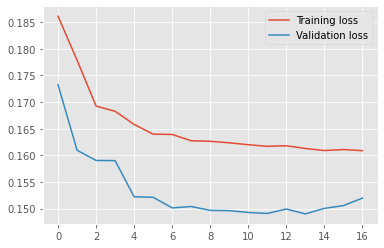

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

Now, predict the entire training data to establish MAE threshold

In [ ]:
X_TRAIN_EMB_predicted = model.predict(X_TRAIN_EMB, batch_size=batch_size, verbose=1)

1440/1440 [==============================] - 7s 5ms/step


In [ ]:
X_TRAIN_mae_loss = np.mean(np.abs(X_TRAIN_EMB_predicted - X_TRAIN_EMB), axis=1)
X_TRAIN_mae_loss

array([[0.19931177, 0.18360431, 0.2070122 , ..., 0.02081873, 0.00038675,
        0.00092139],
       [0.1777752 , 0.23682705, 0.22064171, ..., 0.02084751, 0.02042515,
        0.00094802],
       [0.13745756, 0.11340623, 0.13200434, ..., 0.02086228, 0.0002839 ,
        0.02068179],
       ...,
       [0.16688395, 0.20149278, 0.15659355, ..., 0.02071505, 0.00040089,
        0.00093125],
       [0.23172935, 0.1856323 , 0.17973147, ..., 0.02082626, 0.02033715,
        0.00089894],
       [0.0850725 , 0.11322031, 0.08846081, ..., 0.00094216, 0.00025346,
        0.00059453]])

In [ ]:
training_mae_threshold = np.max(X_TRAIN_mae_loss)
print(f'Reconstruction error (MAE) threshold: {training_mae_threshold}')

Reconstruction error (MAE) threshold: 0.8037900793552398


In [ ]:
# from scipy.spatial import distance

# for i in range(len(X_TRAIN_EMB)):
#   if i == 100:
#     break
#   outliers = []
#   total_dist = 0.0  

#   for w in range(len(X_TRAIN_EMB[i])):
#     cos_dist = distance.cosine(X_TRAIN_EMB[i][w], X_TRAIN_EMB_predicted[i][w])
#     total_dist += cos_dist
#     if cos_dist > .55 :
#       # print(new_X[i][w])
#       # if X_TR[10][w] == 'PADDED':
#       #   continue
#       # print(X_TR[10][w])
#       outliers.append(X_TRAIN['tok_sentence'][i][w])
#   print(f'Outliers {i} => {outliers}')

In [ ]:
for i in range(len(X_TRAIN_EMB_predicted)):

  if i == 100:
    break
  
  outliers = []
  for w in range(len(X_TRAIN_EMB_predicted[i])):
    loss = np.mean(np.abs(X_TRAIN_EMB_predicted[i][w] - X_TRAIN_EMB[i][w]))
    if loss > 0.3:
      outliers.append(X_TRAIN['tok_sentence'][i][w])
  print(f'Outliers => {set(outliers)}')

Now, predict the entire test data

In [ ]:
X_TEST_EMB_predicted = model.predict(X_TEST_EMB, batch_size=batch_size, verbose=1)

256/256 [==============================] - 1s 5ms/step


In [ ]:
X_TEST_mae_loss = np.mean(np.abs(X_TEST_EMB_predicted - X_TEST_EMB), axis=1)
X_TEST_mae_loss

array([[2.31019416e-01, 2.77170798e-01, 1.80923964e-01, ...,
        2.07909033e-02, 1.02527034e-03, 1.63055316e-03],
       [1.76053182e-01, 1.86173254e-01, 1.87152746e-01, ...,
        2.08702420e-02, 2.92945062e-04, 8.14768674e-04],
       [2.09694305e-01, 1.68755739e-01, 1.85080145e-01, ...,
        2.08389939e-02, 2.03290001e-02, 8.83757961e-04],
       ...,
       [2.72641789e-01, 3.37545873e-01, 2.25161276e-01, ...,
        2.08249207e-02, 8.60815503e-04, 2.13848233e-02],
       [1.83295541e-01, 1.74433090e-01, 1.26782774e-01, ...,
        2.08111971e-02, 3.03939179e-04, 2.08015908e-02],
       [2.40322689e-01, 1.69819773e-01, 1.58362006e-01, ...,
        2.08959318e-02, 2.98138769e-04, 2.07290994e-02]])

In [ ]:
test_mae_threshold = np.max(X_TEST_mae_loss)
test_mae_threshold

0.7653413999080658

In [ ]:
for i in range(len(X_TEST_EMB_predicted)):  
  outliers = []
  for w in range(len(X_TEST_EMB_predicted[i])):
    loss = np.mean(np.abs(X_TEST_EMB_predicted[i][w] - X_TEST_EMB[i][w]))
    # print(loss)
    if loss > 0.28:
      token = X_TEST['tok_sentence'][i][w]
      if len(token) > 5:
        outliers.append(X_TEST['tok_sentence'][i][w])
  print(f'Outliers {i} => {set(outliers)}')

Outliers 0 => {'thousand', 'celebrations', 'streets', 'turkey', 'evening.', 'international', 'gender', 'equality', 'police', 'campaigners'}
Outliers 1 => {'officer', 'feminist', 'medical', 'davies.', 'britain’s'}
Outliers 2 => {'activists', 'control', 'coronavirus', 'crisis.'}
Outliers 3 => {'voting', 'bipartisan', 'coronavirus', 'speaker', 'majority', 'blamed', 'pelosi', 'package.', 'senate'}
Outliers 4 => {'breitbart', 'browse', 'youtube', 'bungling.'}
Outliers 5 => {'republicans', 'blamed', 'health'}
Outliers 6 => {'george', 'wealth', 'financier', 'begging'}
Outliers 7 => {'supreme', 'control', 'declaration.', 'climate'}
Outliers 8 => {'bloodshed.', 'sheriff', 'school', 'ability'}
Outliers 9 => {'strike', 'suleimani.', 'revered', 'qassim', 'military'}
Outliers 10 => {'country.', 'peaceful', 'democratic', 'violence'}
Outliers 11 => set()
Outliers 12 => {'caught', 'hoped.', 'looking', '“smile”', 'reasons'}
Outliers 13 => {'sanders', 'divergent', 'richest', 'prominently', 'presidential